## Import

In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import seaborn as sns
from sklearn.preprocessing import label_binarize
import os
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score
)

In [ ]:
# Simple CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Download CIFAR-10 Dataset

In [2]:
# Check if CIFAR-10 dataset is downloaded

def load_CIFAR10(batch_size=64):
    # ---------------- Parameters ---------------- #

    num_workers = 0

    # Transform credit to https://sidthoviti.com/fine-tuning-resnet50-pretrained-on-imagenet-for-cifar-10/
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    # ---------------- Transforms ---------------- #
    transform_train =transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ]
    )

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    # --------- Load full dataset without transforms ---------- #
    train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

    # --------- Split indices for train and val ---------- #
    train_size = int(0.8 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    # --------- Manually assign transforms --------- #
    train_dataset.dataset.transform = transform_train  # affects only Subset view
    val_dataset.dataset.transform = transform_train

    # --------- DataLoaders --------- #
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # --------- Test set --------- #
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_CIFAR10(batch_size=64)
classes = test_loader.dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Preview dataset

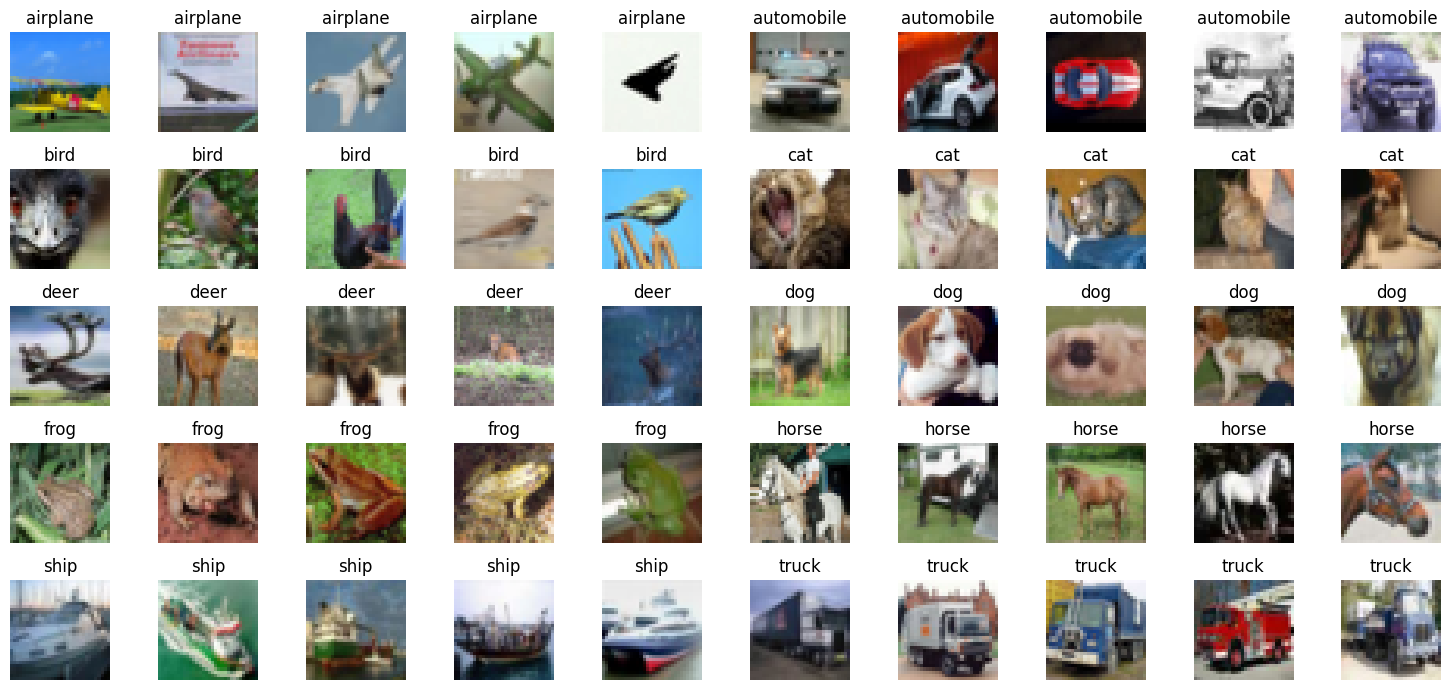

In [ ]:
# Unnormalize tensor to image
def unormalize_image(img_tensor, mean, std):
    img = img_tensor.clone().cpu()  # clone to avoid modifying original
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]  # unnormalize each channel
    img = torch.clamp(img, 0, 1)  # ensure values are in [0,1] range
    return img.permute(1, 2, 0).numpy()

# Visualize the the 10 classes in the dataset with 5 images each
train_dataset = test_loader.dataset
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
class_indices = {class_name: [] for class_name in classes}
for idx, (image, label) in enumerate(train_dataset):
    class_name = classes[label]
    if len(class_indices[class_name]) < 5:
        class_indices[class_name].append(idx)
# Randomly select 5 images from each class
selected_indices = []
for class_name, indices in class_indices.items():
    selected_indices.extend(random.sample(indices, 5))
# Plot the images
fig, axes = plt.subplots(5, 10, figsize=(15, 7))
for i, idx in enumerate(selected_indices):
    image, label = train_dataset[idx]
    image = unormalize_image(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ax = axes[i // 10, i % 10]
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Load trained ResNet50 model in

In [9]:

# Load teacher architecture
#teacher_model = ResNet50(num_classes=10)
teacher_model = models.resnet152(weights="DEFAULT")

teacher_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher_model.maxpool = nn.Identity()  # Remove aggressive downsampling
teacher_model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(teacher_model.fc.in_features, 10))

# Load the pre-trained weights
teacher_path = "resnet152_epoch199_96p.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.to(device)


teacher_checkpoint = torch.load(teacher_path, map_location=device)
teacher_model.load_state_dict(teacher_checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
# Test teacher model on test data
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = teacher_model(images)
        probas = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probas, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probas.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# 3) Overall accuracy & full report
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}\n")

  0%|          | 0/157 [00:11<?, ?it/s]


KeyboardInterrupt: 

## Load student model

In [27]:
from Simple_CNN_V1_model import SimpleCNN
# Load student architecture
student_model = SimpleCNN(num_classes=10)

# Load the pre-trained weights
student_path = "Best_Simple_CNN.pth"
student_checkpoint = torch.load(student_path, map_location=device)
student_model.load_state_dict(student_checkpoint['model_state_dict'])
# Move to device
student_model.to(device)


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): 

In [28]:
# Test student model on test data
y_true = []
y_pred = []
y_score = []
student_model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        probas = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probas, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probas.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# 3) Overall accuracy & full report
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}\n")

100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


Overall Accuracy: 0.8482



## Distillation loss

In [18]:
# Define loss function

def distillation_loss(student_logits, teacher_logits, targets, T=2.0, alpha=0.5):
    """
    student_logits: output from student network (before softmax)
    teacher_logits: output from teacher network (before softmax)
    targets: ground truth labels
    T: temperature for softening
    alpha: weight between soft and hard losses
    """
    # Hard loss
    hard_loss = F.cross_entropy(student_logits, targets,label_smoothing = 0.1)
    
    # Clamp logits to avoid inf/NaN
    student_logits = torch.clamp(student_logits, -100, 100)
    teacher_logits = torch.clamp(teacher_logits, -100, 100)

    # Soft loss (KL divergence with softened logits)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    soft_teacher = F.softmax(teacher_logits / T, dim=1)
    soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

    #print("Hard loss:", hard_loss.item(), "Soft loss:", soft_loss.item())
    # Combined loss
    return alpha * hard_loss + (1 - alpha) * soft_loss

## Training loop

In [32]:
def load_checkpoint(path, model, optimizer=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return (checkpoint['epoch'],
            checkpoint['train_losses'],
            checkpoint['train_accs'],
            checkpoint['val_accs'])

In [20]:
# Set hyperparameters
num_epochs = 200
alpha = 0.4
T = 2.0
lr = 0.001

# Define optimizer
optimizer = optim.Adam(student_model.parameters(), lr=lr)


In [21]:
# Initialize student model

def train_student(student_model, teacher_model, train_loader, optimizer, device, epochs=10, T=2.0, alpha=0.5):
    
    
    
    train_losses = []
    train_accs = []
    val_accs = []
    total_loss, correct, total = 0, 0, 0
    for epoch in tqdm(range(epochs)):
        student_model.train()
        teacher_model.eval()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass through both models
            student_logits = student_model(images)
            with torch.no_grad():
                teacher_logits = teacher_model(images)
                
            # Compute distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, T=T, alpha=alpha)
            
            # Backprop and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and prediction metrics
            total_loss += loss.item()  
            _, predicted = student_logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        # Compute metrics
        student_model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = student_model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        epoch_val_acc = 100.0 * val_correct / val_total
    
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        val_accs.append(epoch_val_acc)

        # Save checkpoint
        torch.save({
        'epoch': epoch,
        'model_state_dict': student_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
    }, "KD_student_model"+str(epoch)+".pth")
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Val Accuracy: {epoch_val_acc:.2f}%")


In [22]:
# Train the student model
train_student(student_model, teacher_model, train_loader, optimizer, device, epochs=num_epochs, T=T, alpha=alpha)

  0%|          | 0/200 [00:35<?, ?it/s]


KeyboardInterrupt: 

# Export model

## Evaluate the model

In [2]:
# Model path
model_path = "KD_model_85p.pth"

# Folder path
folder_path = "KD_model_metrics"

In [3]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
model.eval()
start_epoch, train_losses, train_accs, val_accs = load_checkpoint(
        model_path, model)

# Make folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

NameError: name 'SimpleCNN' is not defined

### Training history plots

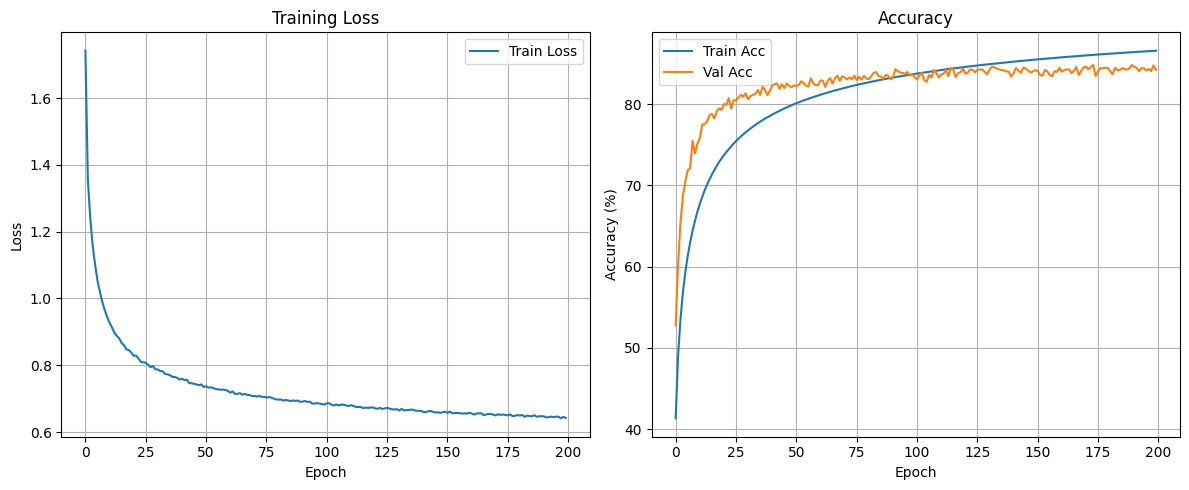

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(folder_path + "/loss_accuracy.png")
plt.show()

### Accuracy

In [46]:
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
y_score = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_score.extend(outputs.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# Compute accuracy
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 157/157 [00:07<00:00, 20.63it/s]

Test Accuracy: 84.22%


### Classification report

In [39]:
model.eval()

# Classification Report
report = classification_report(test_labels, test_preds, target_names=classes)
print(report)
# Save classification report to a text file
with open(folder_path + "/classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    airplane       0.82      0.87      0.85      1000
  automobile       0.93      0.90      0.92      1000
        bird       0.82      0.75      0.78      1000
         cat       0.67      0.76      0.71      1000
        deer       0.88      0.79      0.83      1000
         dog       0.82      0.74      0.78      1000
        frog       0.86      0.90      0.88      1000
       horse       0.86      0.89      0.87      1000
        ship       0.87      0.94      0.90      1000
       truck       0.92      0.89      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## 7. Confusion Matrix Visualization

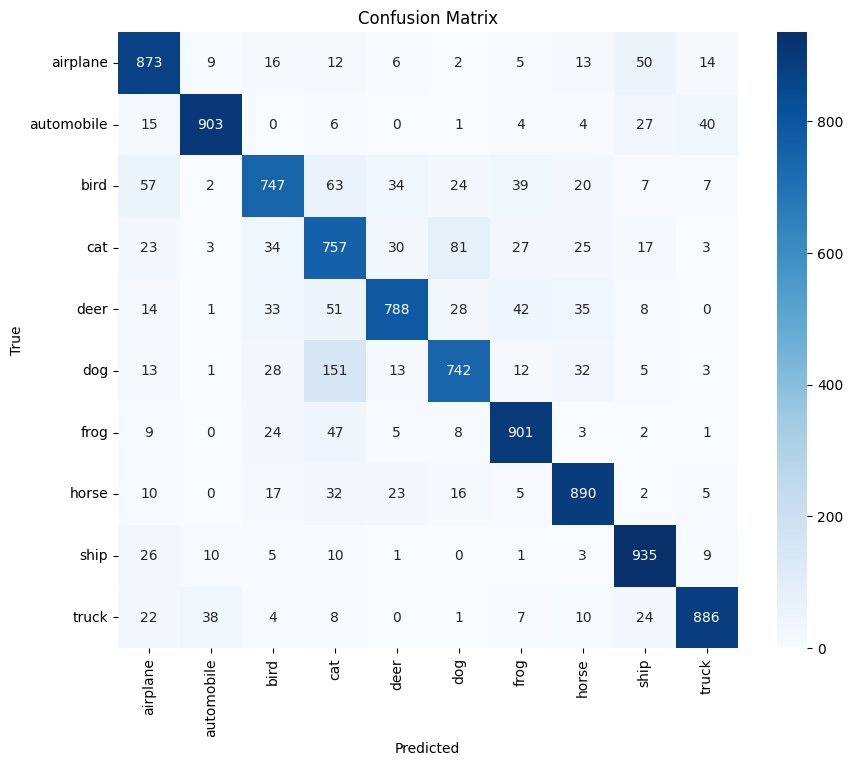

In [40]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(folder_path + "/confusion_matrix.png")
plt.show()

### ROC Curve

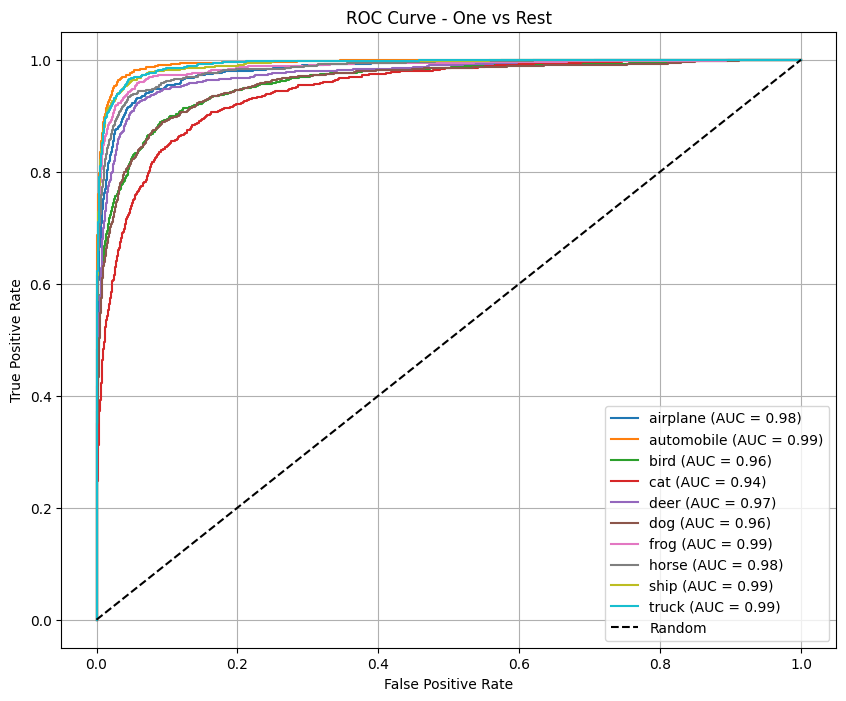

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize labels
n_classes = len(classes)
y_true = label_binarize(test_labels, classes=list(range(n_classes)))
y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - One vs Rest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig(folder_path + "/ROC Curve - One vs Rest.png")
plt.show()